### Date: 22 March 2017

Aim: The aim of this notebook is to learn parameters from Austin region and use them to predict for San Diego region.

We will be computing three approaches.

1. Oracle- uses all data from test (SD) region (leave-one-out CV)
2. Transfer- uses all data from Austin to learn latent factors for appliance and a few homes (k-fold CV) from SD region
3. No transfer- uses (k-fold CV) from SD region

In [1]:
import sys

In [2]:
sys.path.append("../code/")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import sys, traceback
import pandas as pd
import time
import numpy as np
import os
np.random.seed(0)

from common_functions import create_region_df, features_dict, create_feature_combinations, create_df_main
from matrix_factorisation import nmf_features, prepare_df_factorisation,prepare_known_features, create_matrix_factorised, create_prediction

## Learning the appliance factors for fridge from Austin regin

In [5]:
year=2014
seed = 0
test_home=54
test_home_list = [test_home]
train_regions = ["Austin","Boulder","SanDiego"]
train_fraction_dict = {region:0 for region in train_regions}
train_fraction_dict['Austin']=1.0
test_region = 'Austin'
feature_list = ['energy','home']
appliance="fridge"
feature_comb = ['None']
lat = 2

In [6]:
df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                     test_region, test_home_list,
                                                                                     feature_list, seed, 3000, 0)

In [7]:
def f(year, seed, test_home, train_regions, train_fraction_dict,test_region
              , feature_list, appliance, feature_comb, lat, idx_item=None, data_item=None):
    df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                     test_region, test_home,
                                                                                     feature_list, seed, 3000, 0)

    idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)

    A = create_matrix_factorised(appliance, test_home, X_normalised)
    X, Y, res = nmf_features(A=A, k=lat, constant=0.01, regularisation=False,
                        idx_user=idx_user, data_user=data_user,
                         idx_item=idx_item, data_item=data_item, MAX_ITERS=10)
    return X, Y, res, df

In [8]:
X_austin ={}
Y_austin= {}
for appliance in ['fridge','hvac']:
    X_austin[appliance], Y_austin[appliance], res_sd, df_austin = f(year, seed, [22], train_regions, {"Austin":1.0,"Boulder":0,"SanDiego":0}, 
              "Austin", feature_list, appliance, feature_comb, lat)

In [9]:
from common_functions import valid_homes_data

### Oracle

In [10]:
year=2014
seed = 0
train_regions = ["Austin","Boulder","SanDiego"]
train_fraction_dict = {region:0 for region in train_regions}
train_fraction_dict['SanDiego']=1.0
test_region = 'SanDiego'
feature_list = ['energy','home']
feature_comb = ['None']
lat = 2

In [11]:
import sys

In [141]:
def compute_oracle(lat):
    out_oracle = {}
    for appliance in ['fridge','hvac']:

        out_oracle[appliance] = {}


        for i, test_home in enumerate(valid_homes_data['SanDiego'][appliance][:]):
            #print test_home
            test_home_list=[test_home]
            df, dfc, X_matrix, X_normalised, col_max, col_min, appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                              train_fraction_dict,
                                                                                             test_region, test_home_list,
                                                                                             feature_list, seed, 3000, 0)

            idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)
            A = create_matrix_factorised(appliance, test_home_list, X_normalised)



            data_items = None
            idx_items = None
            X, Y, res = nmf_features(A=A, k=lat, constant=0.01, regularisation=False,
                                idx_user=idx_user, data_user=data_user,
                                 idx_item=idx_items, data_item=data_items, MAX_ITERS=10)
            pred_df = create_prediction(test_home, X, Y, X_normalised, appliance,
                                   col_max, col_min, appliance_cols)
            out_oracle[appliance][test_home]=pred_df
    return out_oracle

### Baseline (k-fold on same region, no transfer)

In [142]:
from sklearn.model_selection import KFold

In [143]:
def compute_baselines(lat):
    out_baseline = {}
    for appliance in ['fridge','hvac']:
    #for appliance in ['fridge']:

        out_baseline[appliance] = {}
        for reuse_factors in [True, False]:
        #for reuse_factors in [True]:
            out_baseline[appliance][reuse_factors] = {}
            n_splits=3
            kf = KFold(n_splits=n_splits)
            all_homes = valid_homes_data['SanDiego'][appliance][:]
            temp = {}
            for fold, (test_home_idx, train_home_idx) in enumerate(kf.split(all_homes)):
                temp[fold] = {}

                test_home_list = all_homes[test_home_idx]
                train_home_list = all_homes[train_home_idx]
                #print appliance, reuse_factors, test_home_list, fold
                df, dfc, X_matrix, X_normalised, col_max, col_min, appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                                  train_fraction_dict,
                                                                                                 test_region, test_home_list,
                                                                                                 feature_list, seed, 3000, 0)

                idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)
                A = create_matrix_factorised(appliance, test_home_list, X_normalised)

                if reuse_factors:
                    from collections import OrderedDict
                    data_items = OrderedDict()
                    idx_items = OrderedDict()

                    for count in range(X_austin[appliance].shape[0]):
                        data_items['lat_%d' %count] = np.array(X_austin[appliance][count]).flatten()
                        idx_items['lat_%d' %count] = np.array(range(X_austin[appliance][count].size))
                else:

                    data_items = None
                    idx_items = None




                X, Y, res = nmf_features(A=A, k=lat, constant=0.01, regularisation=False,
                                    idx_user=idx_user, data_user=data_user,
                                     idx_item=idx_items, data_item=data_items, MAX_ITERS=10)
                for test_home in test_home_list:
                    pred_df = create_prediction(test_home, X, Y, X_normalised, appliance,
                                           col_max, col_min, appliance_cols)
                    temp[fold][test_home]=pred_df
            for home in all_homes:
                p =[]

                for fold in range(n_splits):
                    if home in pd.DataFrame(temp[fold]).T.index:
                        p.append(pd.DataFrame(temp[fold]).T.ix[home])
                out_baseline[appliance][reuse_factors][home]=pd.DataFrame(p).mean()
    return out_baseline

In [144]:
ob = {}
ora ={}

In [145]:
for k in [2,3, 4]:
    print k, "baseline"
    ob[k] = compute_baselines(k)
    print k, "oracle"
    ora[k] = compute_oracle(k)

2 baseline
2 oracle
3 baseline
3 oracle
4 baseline
4 oracle


In [128]:
pd.DataFrame(out_baseline['fridge'][True]).T

,fridge_1,fridge_2,fridge_3,fridge_4,fridge_5,fridge_6,fridge_7,fridge_8,fridge_9,fridge_10,fridge_11,fridge_12
54,14.996709,13.548923,16.061430,17.471532,19.101432,19.535040,20.439836,20.560782,19.531640,19.917997,16.892969,17.342539
203,19.647268,17.241433,20.797891,22.700873,24.956581,25.661810,27.183530,27.319379,25.894419,26.324679,22.282411,22.682179
1450,40.678932,37.004438,43.688223,47.485562,51.846966,52.955066,55.242417,55.581687,52.828178,53.913887,45.747721,47.061100
1524,33.368604,28.632062,35.010658,38.313697,42.298559,43.671571,46.685816,46.887652,44.369549,45.003316,38.036840,38.474018
1731,29.829831,27.021906,31.982124,34.779099,38.004128,38.847249,40.599488,40.843245,38.807005,39.586216,33.580332,34.501284
3687,29.595903,27.319969,31.976009,34.695352,37.774515,38.473633,39.875209,40.139690,38.196238,39.045406,33.165926,34.269195
3864,14.550600,12.609221,15.326142,16.752910,18.461211,19.026505,20.258943,20.352465,19.273103,19.567937,16.549442,16.786177
3938,8.752334,8.428530,9.623775,10.389816,11.217833,11.330486,11.514225,11.607943,11.085815,11.389022,9.704607,10.160685
4095,32.917921,28.245445,34.537834,37.796251,41.727269,43.081710,46.055178,46.254288,43.770208,44.395435,37.523065,37.954377
4329,14.952950,14.070976,16.284007,17.628660,19.121018,19.402049,19.933157,20.078672,19.137110,19.606082,16.677210,17.334214


In [102]:
from common_functions import compute_rmse_fraction

In [151]:
res = OrderedDict()
for lat in range(2, 5):
    res[lat]=OrderedDict()
    for appliance in ['hvac','fridge']:
        res[lat][appliance] = OrderedDict()
        res[lat][appliance]['Oracle'] = compute_rmse_fraction(appliance, pd.DataFrame(ora[lat][appliance]).T,
                                                                 "SanDiego")[2]
        for reuse_factors in [True, False]:
            if reuse_factors:
                string = "Transferred from Austin"
            else:
                string = "Learnt from SD"
            res[lat][appliance][string] =compute_rmse_fraction(appliance,pd.DataFrame(ob[lat][appliance][reuse_factors]).T,
                                                             "SanDiego")[2]

In [152]:
%matplotlib inline

In [162]:
pd.Panel(res)

<class 'pandas.core.panel.Panel'>
Dimensions: 3 (items) x 3 (major_axis) x 2 (minor_axis)
Items axis: 2 to 4
Major_axis axis: Learnt from SD to Transferred from Austin
Minor_axis axis: hvac to fridge

In [153]:
pd.DataFrame(res[4])

,hvac,fridge
Learnt from SD,22.428278,7.079287
Oracle,19.314256,7.438766
Transferred from Austin,13.774626,11.139682


In [148]:
pd.DataFrame(res[3])

,hvac,fridge
Learnt from SD,13.347317,7.154839
Oracle,16.594558,7.475647
Transferred from Austin,15.070323,8.369785


In [149]:
pd.DataFrame(res[2])

,hvac,fridge
Learnt from SD,15.224823,6.743818
Oracle,12.545201,7.344456
Transferred from Austin,20.120866,10.314477


In [175]:
from plot_functions import autolabel, latexify, tableau20blind, format_axes
latexify()
r={}
for appliance in ['hvac','fridge']:
    r[appliance]={}
    for l in range(2, 5):
        r[appliance][l]=pd.DataFrame(res[l][appliance]).squeeze()
        
       
#plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer.png",bbox_inches="tight")
#plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer.pdf",bbox_inches="tight")

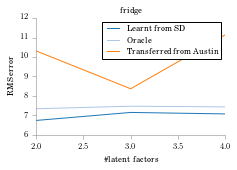

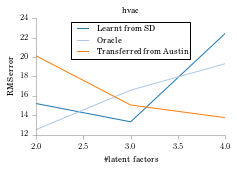

In [184]:
for appliance in ['fridge','hvac']:
    ax = pd.DataFrame(r[appliance]).T.plot()
    format_axes(ax)
    ax.set_title(appliance)
    ax.set_xlabel("\#latent factors")
    ax.set_ylabel("RMS error")
    plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer_latent_%s.png" %appliance,bbox_inches="tight")

In [163]:
from plot_functions import autolabel, latexify, tableau20blind, format_axes
latexify()
ax = pd.DataFrame(res).T[['Oracle','Learnt from SD', 'Transferred from Austin']].plot(kind="line",rot=0, colors=tableau20blind[::2])
plt.ylabel("RMS~error \n(Lower is better)")
plt.legend(loc=3)
rects = ax.patches
autolabel(rects, ax)
format_axes(ax)
#plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer.png",bbox_inches="tight")
#plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer.pdf",bbox_inches="tight")

ValueError: If using all scalar values, you must pass an index

In [ ]:
difference_fraction = {}
for appliance in ['hvac','fridge']:
    difference_fraction[appliance] = {}
    for reuse_factors in [True, False]:
        if reuse_factors:
            string = "Transferred from Austin"
        else:
            string = "Learnt from SD"
        gtf, prf, rms = compute_rmse_fraction(appliance,pd.DataFrame(out[appliance][reuse_factors]).T,
                                                             "SanDiego")
        errors[appliance][string] = (prf-gtf).mean().mean()

In [ ]:
appliance="hvac"
gtf, prf, rms = compute_rmse_fraction(appliance,pd.DataFrame(out[appliance][False]).T,
                                                             "SanDiego")

In [ ]:
gtf_au, prf_au, rms = compute_rmse_fraction(appliance,pd.DataFrame(out[appliance][True]).T,
                                                             "SanDiego")

In [ ]:
prf.describe()

In [ ]:
prf_au.describe()

In [ ]:
X_sd ={}
Y_sd= {}
for appliance in ['fridge','hvac']:
    X_sd[appliance], Y_sd[appliance], res_sd, df_austin = f(year, seed, 54, train_regions, {"Austin":0.0,"Boulder":0,"SanDiego":1.0}, 
              "SanDiego", feature_list, appliance, feature_comb, lat)

In [ ]:
pd.DataFrame(X_sd['fridge']).T.describe()

In [ ]:
pd.DataFrame(X_austin['fridge']).T.describe()

In [ ]:
X_fridge = pd.DataFrame({"Austin":np.array(X_fridge_austin).flatten(),'SanDiego':np.array(X_fridge_sd).flatten()})
X_hvac = pd.DataFrame({"Austin":np.array(X_hvac_austin).flatten(),'SanDiego':np.array(X_hvac_sd).flatten()})

In [ ]:
X_fridge[:12].plot()
plt.xlabel("Month of year")
plt.ylabel("Latent factors for fridge")

In [ ]:
X_hvac[6:].plot()
plt.xlabel("Month of year")
plt.ylabel("Latent factors for HVAC")

In [ ]:
X_fridge.plot()

### Using the fridge latent factors from Austin region

In [ ]:
pd.DataFrame(X).head()

In [ ]:
pd.DataFrame(X_fridge_austin).head()

In [ ]:
X_fridge_sd, Y_fridge_sd, res_sd, df_fridge_sd = f(year, seed, 54, train_regions, {"Austin":0,"Boulder":0,"SanDiego":1}, 
              "SanDiego", feature_list, "fridge", feature_comb, lat)
X_hvac_sd, Y_hvac_sd, res_sd, df_hvac_sd = f(year, seed, 54, train_regions, {"Austin":0,"Boulder":0,"SanDiego":1}, 
              "SanDiego", feature_list, "hvac", feature_comb, lat)